# Textual Analysis of XPN's AtoZ Playlist

One of the cool things about [WXPN](http://xpn.org)
is their frequent special programming which is always interesting.
This year, they put together a multi-day alphabetical playlist
called [XPN's A to Z](http://xpn.org/music-artist/xpn-a-z).
As has been the case for a lot of these events,
the [#XPNAtoZ](https://twitter.com/search?q=%23XPNAtoZ) tweet stream
is as interesting as the music.
Initially I was confused by why
Johnny Cash's _A Boy Named Sue_ was the 3rd song,
when I'd have filed it in the Bs.
So, after getting involved in a 
[twitter exchange](https://twitter.com/brianjgainor/status/803966913483329536)
on the topic of treating articles as significant,
an idea came to me.
I could look at the data to see how words that typically live on stop lists
skewed the distribution of the music.
Along the way other interesting explorations might turn up.
What follows is the result.

## Disclaimer

At present I must point out that this is still a bit preliminary

- At this point, we've into day 11
  and more than half way through the alphabet, 
  But there are still surprises ahead.
- So far the analysis is pretty primitive.
   Mostly a couple of obvious aggregations, 
   as last weekend's project was the nuts and bolts.
   This weekend is likely to be deeper analysis.
- I'm been avoiding spending too much time on improving presentation,
  especially in graphs, until the data stabilizes.

## Load the data

The [AtoZ Playlist page](http://xpn.org/music-artist/xpn-a-z)
contains a directory of songs by first letter.
Behind the scenes, it makes ReST request to their backend.
Eventually I should cache the results,
so this keeps working when they change the site.
But right now while the playlist is still going,
just build a data frame off of the results.

In [4]:
%matplotlib inline
from lxml import html
import requests
import pandas as pd
from IPython.display import display, HTML

alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
letters_so_far = list(alphabet)[:16]
rows = []
for letter in letters_so_far:
    page = requests.get('http://xpn.org/static/az.php?q=%s' %  letter)
    tree = html.fromstring(page.content)
    plays = tree.xpath('//li/text()')
    for play in plays:
        rows.append(play.split(' - ', 1))
playlist = pd.DataFrame(rows, columns=('Title', 'Artist'))

### Data Cleanup and Enrichment

First of all there are some duplicates in the data set.
They don't seem very legitimate, so we start by cleaning them out.

In [5]:
HTML(playlist.loc[playlist.duplicated()].to_html())

,Title,Artist
731,Clocks,Coldplay
2701,Lively Up Yourself,Bob Marley & The Wailers
2718,Lonely Boy,The Black Keys
2811,Love on the Weekend,John Mayer
2816,Love Reign O'er Me,The Who
2826,Love The One You're With,Stephen Stills
3058,Mother's Little Helper,The Rolling Stones
3242,Not Where It's At,Del Amitri
3295,On The Road Again,Canned Heat
3338,One Wing,Wilco


So we delete those.  
We also add a few artificial colums to make reporting easier.
First Letter and First Word are, well the first letter and word of the title.

For what it's worth, "first word" turns out to be a harder problem that it might seem.
For way more detail than a normal human would want,
see the [Word Splitting](Word Splitting.ipynb) notebook.
Short version, any sequence of letters or apostrophes is a word
for our purposes.

In [7]:
# Drop dups
playlist = playlist.drop_duplicates()

# First is the first letter of the title
playlist = playlist.join(playlist.apply(lambda x: x[0][0].upper(), axis=1).to_frame('First Letter'))

from nltk.tokenize import RegexpTokenizer
custom_tokenize = RegexpTokenizer("[\w'\-]+|[^\w'\s\-]").tokenize

# First Word, extract the 'first word' of the title
playlist = playlist.join(playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1).to_frame('First Word'))

So the resulting dataframe has four fields: Title, Artist, First Letter and First Word.
Before diving in, just to get perspective,
here are some basic stats on the data and a dump of the first and last few rows.

In [8]:
HTML(playlist.describe().to_html())

,Title,Artist,First Letter,First Word
count,3403,3403,3403,3403
unique,3161,1249,16,1296
top,Home,The Beatles,I,I
freq,5,88,473,217


In [9]:
HTML(playlist.head(5).to_html())

,Title,Artist,First Letter,First Word
0,ABC,Jackson 5,A,ABC
1,A Big Hunk O' Love,Elvis Presley,A,A
2,A Boy Named Sue (live),Johnny Cash,A,A
3,A Case Of You,Joni Mitchell,A,A
4,A Certain Girl,Ernie K-Doe,A,A


In [10]:
HTML(playlist.tail(5).to_html())

,Title,Artist,First Letter,First Word
3409,Paranoid,Black Sabbath,P,Paranoid
3410,Paranoid Android,Radiohead,P,Paranoid
3411,Paris 1919,John Cale,P,Paris
3412,Parklife,Blur,P,Parklife
3413,Particle Man,They Might Be Giants,P,Particle


## Data Analysis

### Songs by Letter

It's the simplest thing one can look at.
And I wouldn't think it all that interesting.
But given how uneven the distribution has been,
I thought it might be intestesting.
And there have been a few "how long with th I's go"
side conversations.

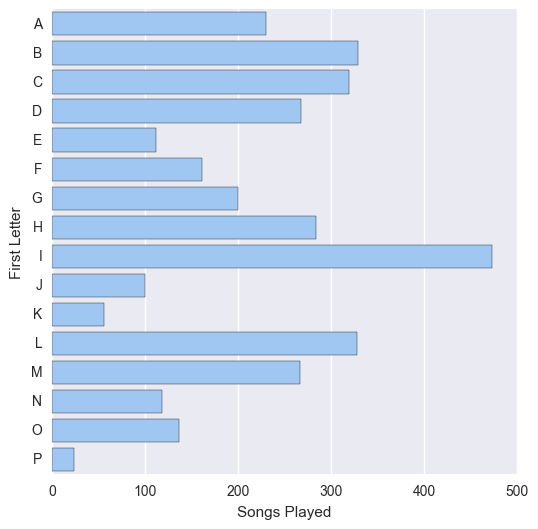

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.countplot(y='First Letter', data=playlist, color='b')
ax.set(xlabel="Songs Played")

### Most Frequent Artists

Even this early in the playlist,
some artists show up often.
This might say something about the music the station plays,
or the listeners as much of this list comes from previous 
playlists like "885 best songs of all time"
or my favorite, the "85 worst songs of all time."
For the moment, let's just look at the most frequent dozen or so.

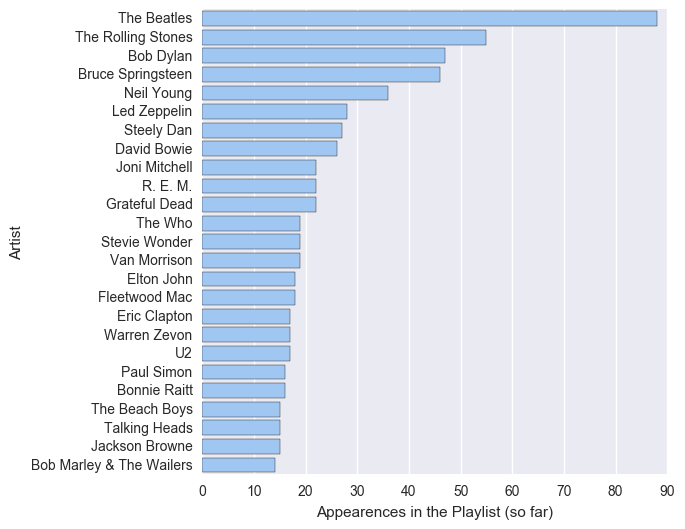

In [12]:
c = playlist['Artist'].value_counts()
artists = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('Artist', 'count'))
f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='Artist', x='count', data=artists.head(25), color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

### Duplicate Titles
From the titles alone, covers and songs that just happen to have the same title
look the same.
But even early on, the number of duplicate titles
was more than I'd have expected.
And a few are more than just duplicated.
In fact, it's crazy that there were four songs called "Crazy",
that that's in a 7 way tie for 3rd place,
and "Home" and "Hold on" have 5 instances each.

What I can't tell is if this all says that there are a fair number of covers in the list,
or if artists just are not that creative at picking names.

In [13]:
title_counts = playlist['Title'].value_counts().to_frame('count')
HTML(title_counts[title_counts['count'] > 2].to_html())

,count
Home,5
Hold On,5
Crazy,4
Fever,4
Hard to Handle,4
Dreams,4
Human,4
It's Alright,4
Fire,4
Night Train,4


### Most Frequent First Words

This is the question that started me down this path.
How much do common "stop words" like articles or propositions 
skew the distribution?
Or do so many songs start with a small set of words
that no amount of pruning would even the distribution out?
Here's an early look a the top 15 first words.
Yes, "A" is up there.
But even early on it wasn't in the lead.
So perhaps my initial concerns were unfounded.
Besides, so far, nothing has come close to the leading word "I".
Maybe songwriters are just a bit narcissistic.

Note that finding the first word is harder than it might seem.


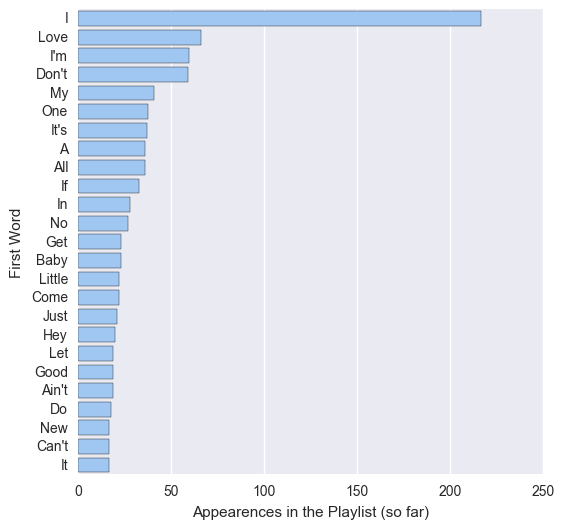

In [14]:
c = playlist['First Word'].value_counts()
words = pd.DataFrame(zip(c.keys().tolist(), c.tolist()),
                       columns=('First Word', 'count'))

f, ax = plt.subplots(figsize=(6, 6))
sns.set_color_codes('pastel')
sns.barplot(y='First Word', x='count', data=words.head(25), color='b')
ax.set(xlabel="Appearences in the Playlist (so far)")

The same data as a word cloud,
though the python wordcloud package does a few things work against us
and are not customizable in the released version.

<function matplotlib.pyplot.show>

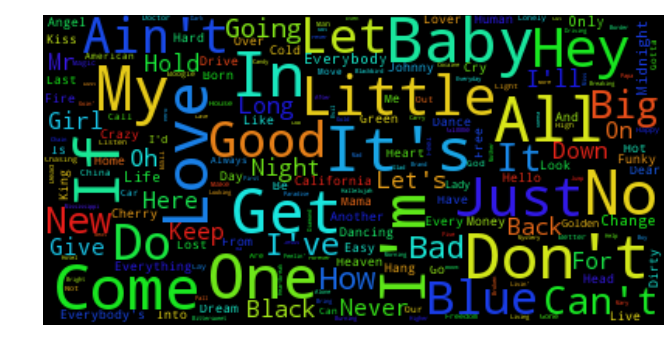

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

firsts = playlist.apply(lambda x: custom_tokenize(x[0])[0], axis=1)
wordcloud = WordCloud(max_font_size=40, stopwords='').generate(' '.join(firsts.tolist()))
plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show


## Availability

The code for this project is in [my git hub repo](https://github.com/asudell/a2z).
The notebook its self is [published on nbviewer](http://nbviewer.jupyter.org/github/asudell/a2z/blob/master/AtoZ.ipynb)

## License

This project is licensed under a
[Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).
You are free to use for commercial or non-commercial purposes,
so long as you attribute the source and also allow sharing.

## Related Efforts

Apparently I'm not the only one who thought to do something like this.
Checkout [Bruce Segal's work](https://public.tableau.com/profile/besegal#!/vizhome/BESegalWXPNAtoZPlayListPublished/XPNAtoZFindYourSongfromAtoZ)
as well as [Lena Bartel's work](https://public.tableau.com/profile/lena.bartell#!/vizhome/XPN_AtoZ/XPNA-ZPlaylistData).
